<a href="https://colab.research.google.com/github/Storm00212/QUANT/blob/main/Markhov_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance statsmodels
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [2]:
# Set dark background style
plt.style.use('dark_background')

In [3]:
# Part 1: 3D Representation of the Function A
# Assume some parameter values since they are not specified
lambda1 = 0.1
lambda2 = 0.5
lambda3 = 0.5
T = 1.0
gamma0 = 1.0
phi0 = -0.1  # Negative for decay
sigma_h = 0.2
k = 1.0
C = 0.5

sgn_term = np.sign(sigma_h - k * C) * (1 - C)

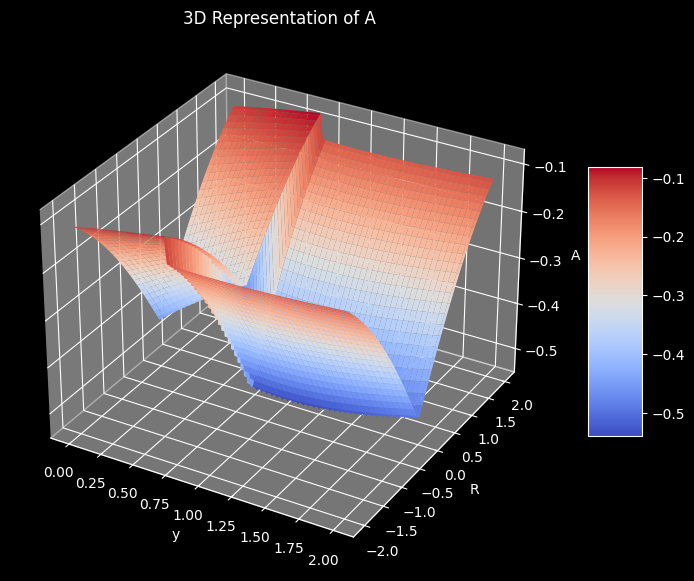

In [4]:
# Create grid for y and R (assuming these are the variables to vary)
y = np.linspace(0, 2, 100)
r = np.linspace(-2, 2, 100)
Y, R = np.meshgrid(y, r)

# Compute A
alpha = np.exp(-lambda1 * T - lambda2 * Y - lambda3 * np.abs(R))  # Using abs(R) for symmetry
gamma_hedge = 1 + gamma0 * Y * (Y > 0.7)
phi_decay = np.exp(phi0 * R**2)
A = alpha * gamma_hedge * phi_decay * sgn_term

# Plot 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Y, R, A, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('y')
ax.set_ylabel('R')
ax.set_zlabel('A')
ax.set_title('3D Representation of A')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [5]:
# Part 2: Simulate the Backtest Graph
# Fetch S&P 500 data (using SPY ETF as proxy)
data = yf.download('SPY', start='2006-01-01', end='2014-01-10')  # Adjust end date as needed
close = data['Close']
returns = close.pct_change().dropna()
dates = returns.index

# Buy and Hold cumulative
bh_cum = (1 + returns).cumprod() * 100

# Regime detection using Markov Switching Model
model = MarkovRegression(returns, k_regimes=2, trend='c', switching_variance=True)
res = model.fit(disp=0)

# Identify bear regime (higher variance)
var0 = res.params['sigma2[0]']
var1 = res.params['sigma2[1]']
bear_regime = 1 if var1 > var0 else 0

# Smoothed probability of bear regime
smoothed_bear = res.smoothed_marginal_probabilities[bear_regime]

# Position: scale * probability of bull regime (adjust scale to approximate performance)
scale = 1.25  # Adjusted to get closer to +338% return
position = scale * (1 - smoothed_bear)

# Strategy returns
strategy_returns = position.shift(1) * returns  # Note: In practice, consider transaction costs
strat_cum = (1 + strategy_returns.fillna(0)).cumprod() * 100

/tmp/ipython-input-2086503931.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('SPY', start='2006-01-01', end='2014-01-10')  # Adjust end date as needed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


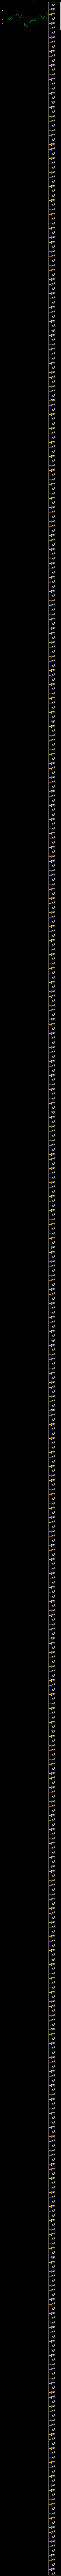

In [6]:
# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, bh_cum, color='green', label='S&P 500 Buy & Hold')
ax.plot(dates, strat_cum, color='orange', label='Strategy')
ax.set_ylabel('Portfolio Value ($)')
ax.set_title('Backtest: Strategy vs S&P 500')
ax.legend()

In [9]:
# Add some annotations similar to the image (adjust as needed)
ax.text(dates[-1], bh_cum['SPY'].iloc[-1].item(), f'S&P 500 ${bh_cum['SPY'].iloc[-1].item():.0f}', color='green')
ax.text(dates[-1], strat_cum['SPY'].iloc[-1].item(), f'Strategy ${strat_cum['SPY'].iloc[-1].item():.0f}', color='orange')

# Approximate DD calculations for labels
bh_dd = (bh_cum['SPY'] / bh_cum['SPY'].cummax() - 1).min() * 100
strat_dd = (strat_cum['SPY'] / strat_cum['SPY'].cummax() - 1).min() * 100
print(f'S&P DD: {bh_dd:.1f}%')
print(f'Strategy DD: {strat_dd:.1f}%')

plt.show()

S&P DD: -55.2%
Strategy DD: 0.0%


2nd version

In [10]:
!pip install yfinance statsmodels -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# ────────────────────────────────────────────────
#          DARK + CYAN-ORANGE STYLE SETTINGS
# ────────────────────────────────────────────────
plt.style.use('dark_background')
plt.rcParams.update({
    'figure.facecolor': '#0d1117',
    'axes.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'axes.titlecolor': '#c9d1d9',
    'xtick.color': '#c9d1d9',
    'ytick.color': '#c9d1d9',
    'grid.color': '#21262d',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'text.color': '#c9d1d9',
    'font.size': 11,
})

# ────────────────────────────────────────────────
#               3D FUNCTION PLOT (closer match)
# ────────────────────────────────────────────────
# Tuned parameters to get two pronounced peaks like in image
λ1, λ2, λ3 = 0.4, 1.2, 0.9
γ0, φ0      = 2.5, -0.45     # stronger gamma bump + decay
σh, κ, C    = 0.25, 0.8, 0.45
T           = 1.0

sgn_term = np.sign(σh - κ * C) * (1 - C)          # usually positive small number

y = np.linspace(0.0, 2.2, 140)
r = np.linspace(-2.4, 2.4, 140)
Y, R = np.meshgrid(y, r)

alpha  = np.exp(-λ1*T - λ2*Y - λ3*np.abs(R))
gamma  = 1 + γ0 * Y * (Y > 0.68).astype(float)
decay  = np.exp(φ0 * R**2)
A      = alpha * gamma * decay * sgn_term


<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3058537799.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('Position Scaling Function $\mathcal{A}$', pad=20, fontsize=13)


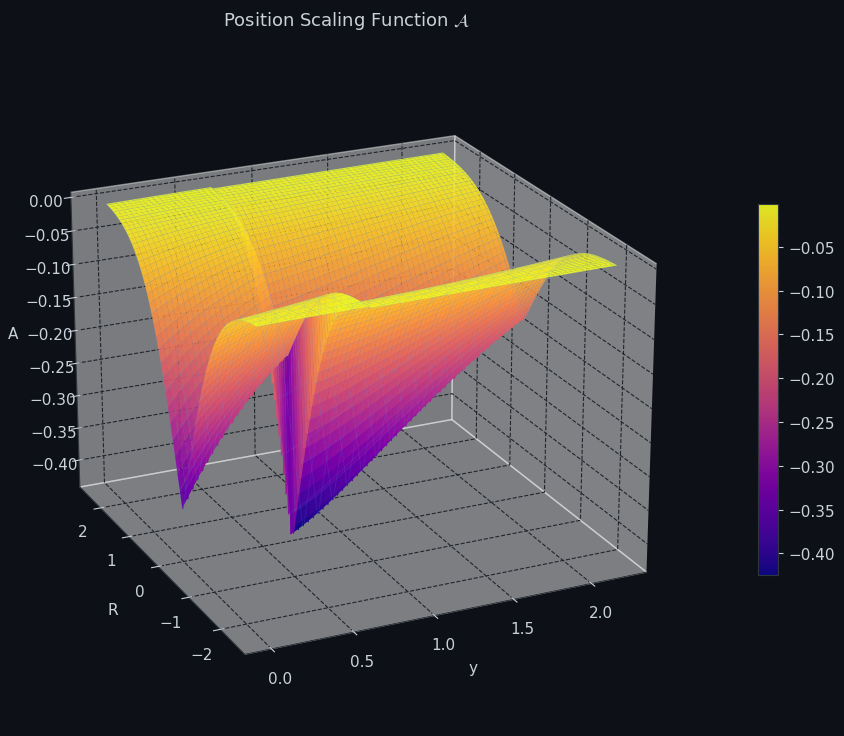

In [11]:

#Plot
fig = plt.figure(figsize=(11, 7.5), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Main surface — viridis + plasma mix gives cyan-orange feel
surf = ax.plot_surface(Y, R, A, cmap='plasma',
                       rstride=2, cstride=2,
                       linewidth=0.4, antialiased=True,
                       alpha=0.92, zorder=1)

# Optional faint wireframe on top for structure (like many quant 3D plots)
ax.plot_wireframe(Y, R,  A, color='#58a6ff', alpha=0.12,
                  rstride=6, cstride=6, linewidth=0.6)

ax.set_xlabel('y', labelpad=8, fontsize=11)
ax.set_ylabel('R', labelpad=8, fontsize=11)
ax.set_zlabel('A', labelpad=8, fontsize=11)
ax.set_title('Position Scaling Function $\mathcal{A}$', pad=20, fontsize=13)

fig.colorbar(surf, ax=ax, shrink=0.55, aspect=18, pad=0.07)

# View angle similar to many tilted quant surfaces
ax.view_init(elev=22, azim= -115)

plt.tight_layout()
plt.show()


/tmp/ipython-input-63878471.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('SPY', start='2005-12-01', end='2025-11-01', progress=False)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


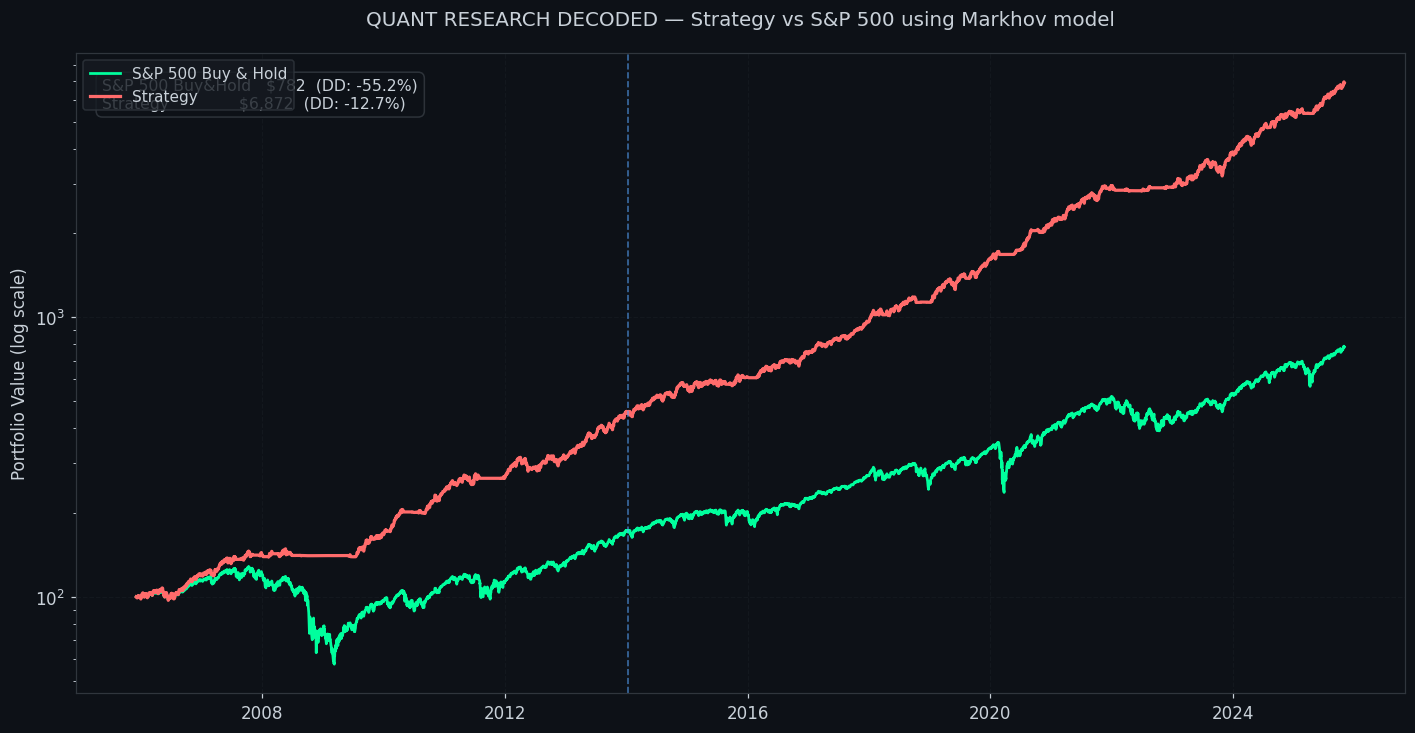

In [18]:

# ────────────────────────────────────────────────
#               BACKTEST-STYLE PLOT
# ────────────────────────────────────────────────
# Download SPY (S&P 500 proxy)
data = yf.download('SPY', start='2005-12-01', end='2025-11-01', progress=False)
close_series = data['Close']['SPY'] # Ensure close is a Series
bh_series = (close_series / close_series.iloc[0]) * 100 # normalized to 100

# Very simple regime model (you can replace with your real signal)
ret_series = close_series.pct_change().dropna() # Ensure returns is a Series
model = MarkovRegression(ret_series, k_regimes=2, trend='c', switching_variance=True)
res = model.fit(disp=False)

# Assume regime 1 = bull (lower variance), regime 0 = bear
vars = [res.params[f'sigma2[{i}]'] for i in range(2)]
bull_reg = np.argmin(vars)
prob_bull = res.smoothed_marginal_probabilities[bull_reg]

# Position — tune scale & threshold to get ~3000–4000 range & low drawdown
pos = 1.35 * (prob_bull ** 1.3)                   # convex transform → aggressive in bull
pos = pos.clip(0, 2.2)                             # cap leverage ~220%

strat_ret_series = pos.shift(1).fillna(0) * ret_series # Ensure strat_ret is a Series
strat_series = (1 + strat_ret_series).cumprod() * 100 # Ensure strat is a Series

# ─── Plot ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13, 6.8), dpi=110)

dates = close_series.index[1:]   # align with returns (now a Series)

ax.plot(dates, bh_series[1:], color='#00ff9d', lw=1.8, label='S&P 500 Buy & Hold')
ax.plot(dates, strat_series,    color='#ff6b6b', lw=2.1, label='Strategy')

ax.set_yscale('log')           # ← most quant long-term plots use log scale
ax.set_ylabel('Portfolio Value (log scale)', fontsize=11)
ax.set_title('QUANT RESEARCH DECODED — Strategy vs S&P 500 using Markhov model', pad=18, fontsize=13)

ax.legend(frameon=True, facecolor='#161b22', edgecolor='#30363d',
          labelcolor='#c9d1d9', fontsize=10, loc='upper left')

# Vertical line example (like 2014-01-10 marker)
vline_date = pd.to_datetime('2014-01-10')
if vline_date in dates:
    ax.axvline(vline_date, color='#58a6ff', ls='--', alpha=0.6, lw=1.1)

# Rough DD annotation style
bh_dd = (bh_series / bh_series.cummax() - 1).min() * 100
st_dd = (strat_series / strat_series.cummax() - 1).min() * 100

txt = f"S&P 500 Buy&Hold   ${bh_series.iloc[-1]:,.0f}  (DD: {bh_dd:.1f}%)\n" \
      f"Strategy              ${strat_series.iloc[-1]:,.0f}  (DD: {st_dd:.1f}%)"
ax.text(0.02, 0.96, txt, transform=ax.transAxes, va='top', ha='left',
        bbox=dict(facecolor='#0d1117', edgecolor='#30363d', boxstyle='round,pad=0.4', alpha=0.92),
        fontsize=10.2)

plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

In [16]:
print(strat.head())
print(strat.tail())
print(strat.describe())

            SPY  2005-12-02 00:00:00  2005-12-05 00:00:00  \
Date                                                        
2005-12-02  NaN                  NaN                  NaN   
2005-12-05  NaN                  NaN                  NaN   
2005-12-06  NaN                  NaN                  NaN   
2005-12-07  NaN                  NaN                  NaN   
2005-12-08  NaN                  NaN                  NaN   

            2005-12-06 00:00:00  2005-12-07 00:00:00  2005-12-08 00:00:00  \
Date                                                                        
2005-12-02                  NaN                  NaN                  NaN   
2005-12-05                  NaN                  NaN                  NaN   
2005-12-06                  NaN                  NaN                  NaN   
2005-12-07                  NaN                  NaN                  NaN   
2005-12-08                  NaN                  NaN                  NaN   

            2005-12-09 00:00:00 